$$
h_{i,k00}^{(0)} = \sum_z W_{kz} \delta_{zzi}
$$

$$
\tilde{h}_{i,k_1l_2m_2}^{(s)} = \sum_k W_{kk_1}^{(s)} h_{i,k_2l_2m_2}^{(s)}
$$

$$
j_{0}^{n}(r_{ij}) = \sqrt{\frac{2}{r_{\text{cut}}}} \frac{\sin \left( \pi n \frac{r_{ij}}{r_{\text{cut}}} \right)}{r_{ij}} f_{\text{cut}}(r_{ij})
$$

$$
R_{k\eta_1l_1l_2l_3}^{(s)}(r_{ij}) = \text{MLP} \left( \left\{ j_{0}^{n}(r_{ij}) \right\}_n \right)
$$

$$
\phi_{ij,k\eta_1l_3m_3}^{(s)} = \sum_{l_1l_2m_1m_2} c_{l_3m_3}^{\eta_1m_1l_1m_2} R_{k\eta_1l_1l_2l_3}^{(s)}(r_{ij}) \times Y_{l_1}^{m_1}(\hat{r}_{ij}) \tilde{h}_{j,k_2l_2m_2}^{(s)}
$$

$$
A_{i,k_1l_3m_3}^{(s)} = \sum_{\tilde{k}\eta1} W_{kk\eta1}^{(s)} \sum_{j \in \mathcal{N}(i)} \phi_{ij,k\eta_1l_3m_3}^{(s)}
$$

$$
A_{i,klm}^{(s), \nu} = \prod_{\xi=1}^{\nu} A_{i,k\xi lm2}^{(s)}
$$

$$
B_{i,\eta\gamma kLM}^{(s), \nu} = \sum_{lm} C_{LM}^{\nu lm} A_{i,klm}^{(s), \nu}
$$

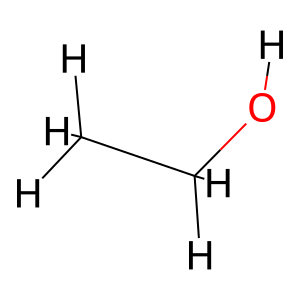

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

# Define the SMILES string
smiles = 'CCO'  # Example: Ethanol

# Create a molecule object from the SMILES string
molecule = Chem.MolFromSmiles(smiles)

# Add hydrogens to the molecule
molecule = Chem.AddHs(molecule)

# Generate 3D coordinates
AllChem.EmbedMolecule(molecule, randomSeed=42)
ff = AllChem.UFFOptimizeMolecule(molecule)

# Display the molecule
Draw.MolToImage(molecule)

In [3]:
from ase import Atoms
import nglview as nv

# Function to convert RDKit molecule to ASE Atoms object
def rdkit_to_ase(molecule):
    conformer = molecule.GetConformer()
    symbols = [atom.GetSymbol() for atom in molecule.GetAtoms()]
    positions = [conformer.GetAtomPosition(atom.GetIdx()) for atom in molecule.GetAtoms()]
    positions = [(pos.x, pos.y, pos.z) for pos in positions]
    ase_atoms = Atoms(symbols=symbols, positions=positions)
    return ase_atoms

at = rdkit_to_ase(molecule)
view = nv.show_ase(at)
view.add_representation('label', 
                        selection='*', 
                        labelType='atomindex', 
                        color='black',
                        zOffset=1.0)
view

NGLWidget()

In [4]:
from mace import data, tools

Rcut = 3.0
Nmax = 4


z_table = tools.AtomicNumberTable([1, 6, 8])

config = data.Configuration(
    atomic_numbers=at.numbers,
    positions=at.positions
)

data = data.AtomicData.from_config(config, z_table=z_table, cutoff=Rcut)
data.__dict__

{'x': None,
 'edge_index': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3,
          3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
          6, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8],
         [1, 2, 3, 4, 5, 6, 7, 8, 0, 2, 3, 4, 5, 6, 7, 8, 0, 1, 3, 5, 6, 7, 8, 0,
          1, 2, 4, 5, 6, 8, 0, 1, 3, 5, 6, 7, 0, 1, 2, 3, 4, 7, 0, 1, 2, 3, 4, 7,
          8, 0, 1, 2, 4, 5, 6, 8, 0, 1, 2, 3, 6, 7]]),
 'edge_attr': None,
 'y': None,
 'pos': None,
 'normal': None,
 'face': None,
 '__num_nodes__': 9,
 'positions': tensor([[-0.9257,  0.0738,  0.0244],
         [ 0.5132, -0.4192, -0.0683],
         [ 1.3722,  0.4522,  0.6151],
         [-1.0191,  1.0710, -0.4556],
         [-1.5998, -0.6393, -0.4952],
         [-1.2334,  0.1504,  1.0888],
         [ 0.8161, -0.5095, -1.1362],
         [ 0.5825, -1.4258,  0.3954],
         [ 1.4939,  1.2463,  0.0317]]),
 'shifts': tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
   

In [5]:
from mace.modules.utils import get_edge_vectors_and_lengths

vectors, lengths = get_edge_vectors_and_lengths(
    positions=data["positions"],
    edge_index=data["edge_index"],
    shifts=data["shifts"],
)

## 1. Species embedding

$$
h_{i,k00}^{(0)} = \sum_z W_{kz} \delta_{zz_i}
$$

$$
\delta_{zz_i}
$$


In [6]:
import torch
from mace import tools

z_table = tools.get_atomic_number_table_from_zs(at.numbers)
num_elements = len(z_table)

indices = tools.utils.atomic_numbers_to_indices(at.numbers, z_table=z_table)
indices_torch = torch.tensor(indices, dtype=torch.int64).unsqueeze(-1)
node_attrs = tools.torch_tools.to_one_hot(indices_torch,num_classes=num_elements)

print(node_attrs)

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


In [7]:
# import torch
# import torch.nn as nn

# model = nn.Sequential()

# model.add_module('W0', nn.Linear(8, 16))
# model.add_module('tanh', nn.Tanh())
# model.add_module('W1', nn.Linear(16, 1))

# x = torch.randn(100, 8)
# y = model(x)

## 2. Radial Basis
$$
j_{0}^{n}(r_{ij}) = \sqrt{\frac{2}{r_{\text{cut}}}} \frac{\sin \left( \pi n \frac{r_{ij}}{r_{\text{cut}}} \right)}{r_{ij}} f_{\text{cut}}(r_{ij})
$$

In [7]:
from mace.modules.blocks import BesselBasis

bessel_fn = BesselBasis(r_max=Rcut, num_basis=Nmax)

In [8]:
radial = bessel_fn(lengths)

/opt/conda/lib/python3.10/site-packages/mace/modules/radial.py:50: RuntimeWarning: invalid value encountered in divide
  return self.prefactor * (numerator / x)


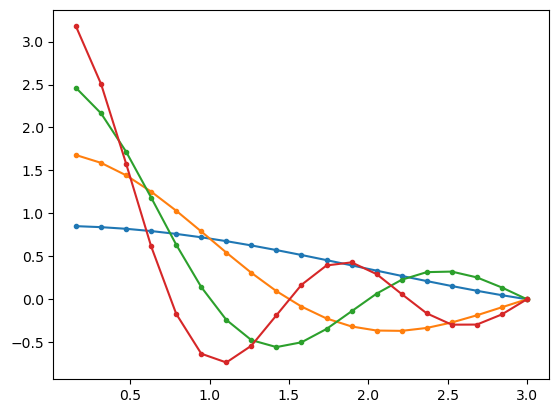

In [9]:
import numpy as np
from matplotlib import pyplot as plt

dists = np.linspace(0,Rcut,20).reshape(-1,1)
plt.plot(dists, bessel_fn(dists), '.-');

https://docs.e3nn.org/en/stable/api/o3/o3_tp.html

FullTensorProduct(2x0e+3x1o x 5x0e+7x1e -> 21x0o+10x0e+36x1o+14x1e+21x2o | 102 paths | 0 weights)


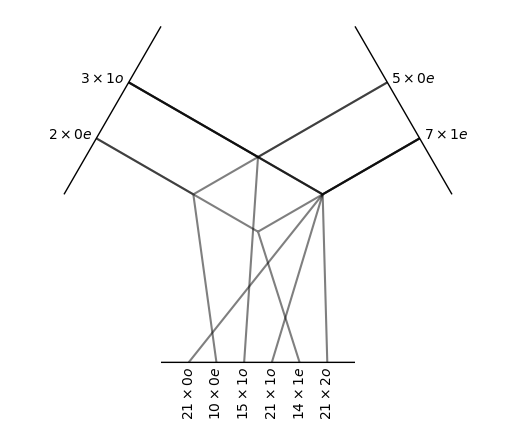

In [4]:
from e3nn import o3
import warnings
warnings.filterwarnings("ignore") 

tp = o3.FullTensorProduct(
    irreps_in1='2x0e + 3x1o',
    irreps_in2='5x0e + 7x1e'
)
print(tp)
tp.visualize();

FullyConnectedTensorProduct(5x0e+5x1e x 6x0e+4x1e -> 15x0e+3x1e | 960 paths | 960 weights)


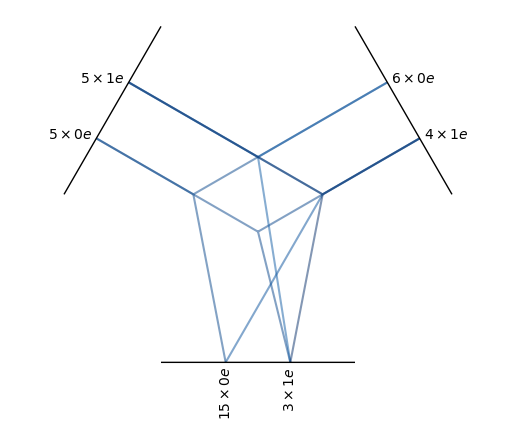

In [5]:
tp = o3.FullyConnectedTensorProduct(
    irreps_in1='5x0e + 5x1e',
    irreps_in2='6x0e + 4x1e',
    irreps_out='15x0e + 3x1e'
)
print(tp)
tp.visualize();

FullTensorProduct(1x0e+1x1o x 1x0o+1x1e -> 2x0o+1x1o+2x1e+1x2o | 6 paths | 0 weights)


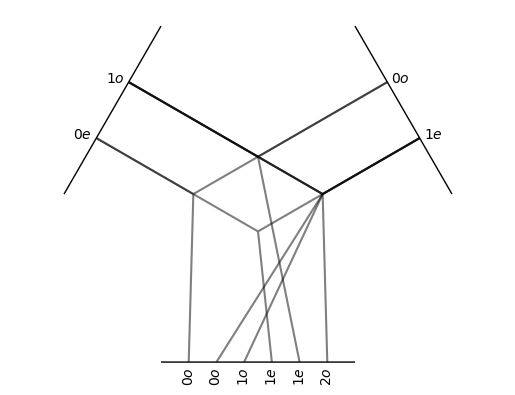

In [32]:
from e3nn import o3
import torch
import warnings
warnings.filterwarnings("ignore") 

tp = o3.FullTensorProduct(
    irreps_in1='1x0e + 1x1o',
    irreps_in2='1x0o + 1x1e'
)
print(tp)
tp.visualize();

In [43]:
input1 = torch.randn(1 + 1 * 3)-0.5  # '1x0e' has 1 element, '1x1o' has 3 elements each with 3 components (x, y, z)
input2 = torch.randn(1 + 1 * 3)-0.5  # '1x0o' has 1 element, '1x1e' has 3 elements each with 3 components (x, y, z)

print(input1)
print(input2)

tensor([ 2.2658, -2.0374, -0.7821, -0.2102])
tensor([ 0.3476, -1.5251,  1.5428,  1.1366])


In [44]:
tp(input1, input2)

tensor([ 0.7877,  0.9594, -0.3993,  1.8642, -3.0661, -3.4555,  3.4956,  2.5753,
        -0.7083, -0.2719, -0.0731, -1.4108, -1.3792, -2.1562, -0.8579, -2.3661])

In [30]:
input1[0]*input2[0]

tensor(-0.0878)

FullTensorProduct(1x1o x 1x1o -> 1x0e+1x1e+1x2e | 3 paths | 0 weights)


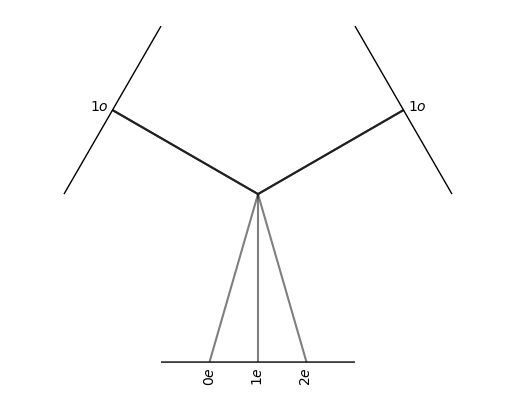

In [49]:
from e3nn import o3
import torch
import warnings
warnings.filterwarnings("ignore") 

tp = o3.FullTensorProduct(
    irreps_in1='1x1o',
    irreps_in2='1x1o'
)
print(tp)
tp.visualize();

In [56]:
torch.manual_seed(123)
input1 = torch.randn(1 * 3)-0.5
input2 = torch.randn(1 * 3)-0.5
tp(input1, input2)

tensor([ 0.7793, -0.9654,  0.3296,  0.5349,  0.5810,  0.9325,  0.2380,  1.1215,
        -0.1414])

In [61]:
v1 = torch.FloatTensor([1,1,1])
v2 = torch.FloatTensor([1,1,1])
tp(v1, v2)

tensor([1.7321, 0.0000, 0.0000, 0.0000, 1.4142, 1.4142, 0.0000, 1.4142, 0.0000])

https://docs.e3nn.org/en/stable/index.html

In [62]:
import torch
from e3nn import o3

irreps_x = o3.Irreps('2x1o')
irreps_y = o3.Irreps('0e + 1e')

x = irreps_x.randn(-1)
y = irreps_y.randn(-1)

irreps_x.dim, irreps_y.dim

(6, 4)

In [63]:
x

tensor([-0.9724, -0.7550,  0.3239, -0.1085,  0.2103, -0.3908])

In [64]:
y

tensor([0.2350, 0.6653, 0.3528, 0.9728])

In [65]:
A = torch.einsum('i,j', x, y)
A

tensor([[-0.2285, -0.6469, -0.3431, -0.9459],
        [-0.1774, -0.5023, -0.2664, -0.7345],
        [ 0.0761,  0.2155,  0.1143,  0.3151],
        [-0.0255, -0.0722, -0.0383, -0.1056],
        [ 0.0494,  0.1399,  0.0742,  0.2046],
        [-0.0918, -0.2600, -0.1379, -0.3802]])

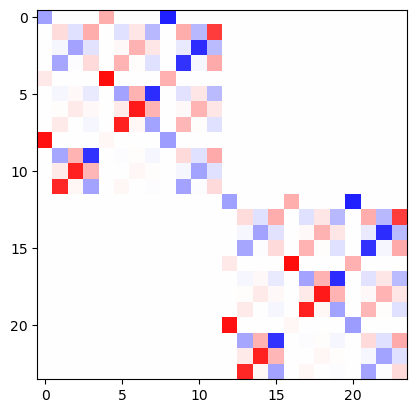

In [69]:
from matplotlib import pyplot as plt

R = o3.rand_matrix()
D_x = irreps_x.D_from_matrix(R)
D_y = irreps_y.D_from_matrix(R)

plt.imshow(torch.kron(D_x, D_y), cmap='bwr', vmin=-1, vmax=1);

FullTensorProduct(2x1o x 1x0e+1x1e -> 2x0o+4x1o+2x2o | 8 paths | 0 weights)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

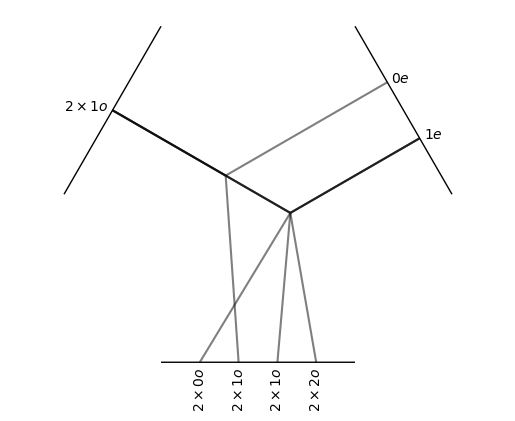

In [72]:
tp = o3.FullTensorProduct(irreps_x, irreps_y)
print(tp)
tp.visualize()

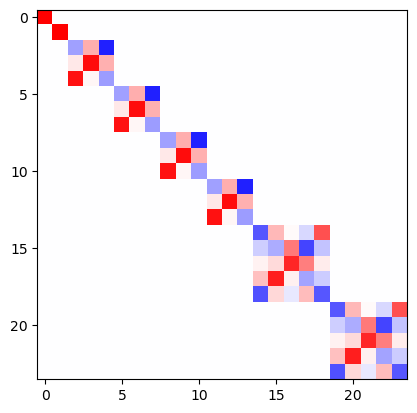

In [73]:
D = tp.irreps_out.D_from_matrix(R)
plt.imshow(D, cmap='bwr', vmin=-1, vmax=1);